In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
fs_type = 'fsv24'

fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 147
Categorical features: 8
Text features: 0


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=True,
    scale_type='minmax',
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 219
Categorical Columns: 8


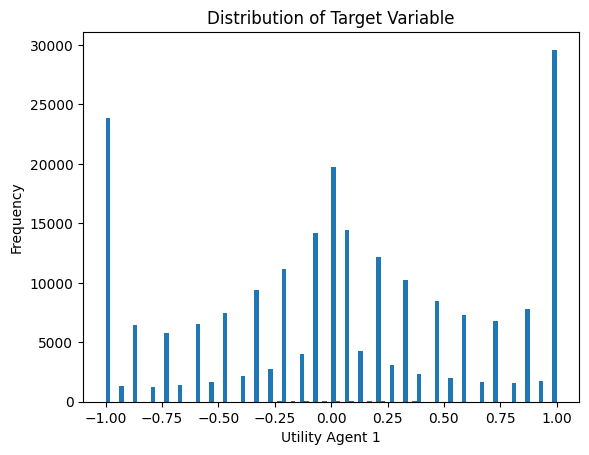

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [7]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        # 'boosting': 'dart',
        # 'drop_rate': 0.1,
        # 'max_drop': 50,
        # 'skip_drop': 0.6,
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        #'extra_trees': True,
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': 0.05,
        #'reg_alpha': 1e-1,
        #'reg_lambda': 1e-1,
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,

        'linear_tree': True,
        'linear_lambda': 1e-1,
        
        #'cat_l2': 1.,
        #'max_cat_threshold': 32
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=5000,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1
[100]	valid_0's rmse: 0.463538
[200]	valid_0's rmse: 0.45065
[300]	valid_0's rmse: 0.442608
[400]	valid_0's rmse: 0.43912
[500]	valid_0's rmse: 0.436194
[600]	valid_0's rmse: 0.43441
[700]	valid_0's rmse: 0.432564
[800]	valid_0's rmse: 0.431527
[900]	valid_0's rmse: 0.430457
[1000]	valid_0's rmse: 0.429793
[1100]	valid_0's rmse: 0.429127
[1200]	valid_0's rmse: 0.428598
[1300]	valid_0's rmse: 0.428011
[1400]	valid_0's rmse: 0.427658
[1500]	valid_0's rmse: 0.427585
[1600]	valid_0's rmse: 0.427518
[1700]	valid_0's rmse: 0.427236
[1800]	valid_0's rmse: 0.427004
[1900]	valid_0's rmse: 0.426612
[2000]	valid_0's rmse: 0.426377
[2100]	valid_0's rmse: 0.426283
[2200]	valid_0's rmse: 0.426008
[2300]	valid_0's rmse: 0.425935
[2400]	valid_0's rmse: 0.425792
[2500]	valid_0's rmse: 0.426022
[2600]	valid_0's rmse: 0.425897
[2700]	valid_0's rmse: 0.425913
[2800]	valid_0's rmse: 0.425952
[2900]	valid_0's rmse: 0.426048
[3000]	valid_0's rmse: 0.425989
[3100]	valid_0's rmse: 0.426001
[3200]	valid_

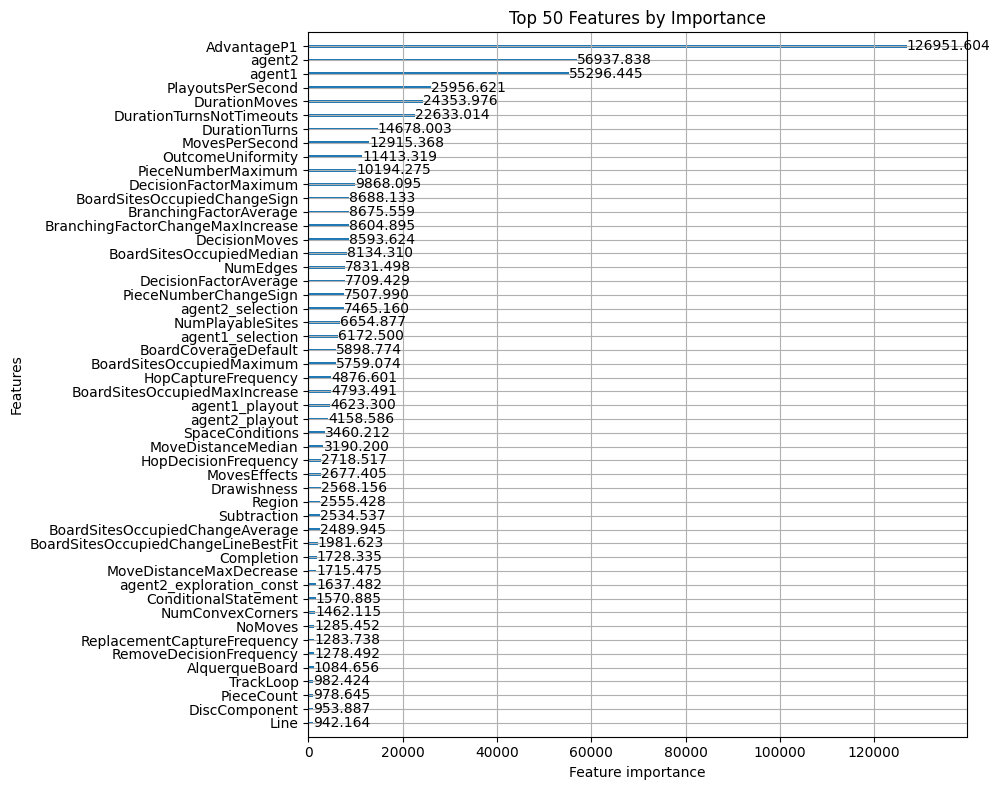

Fold 1 - RMSE: 0.4251919318977863
Fold 2
[100]	valid_0's rmse: 0.491401
[200]	valid_0's rmse: 0.479926
[300]	valid_0's rmse: 0.475108
[400]	valid_0's rmse: 0.471811
[500]	valid_0's rmse: 0.469476
[600]	valid_0's rmse: 0.46752
[700]	valid_0's rmse: 0.465485
[800]	valid_0's rmse: 0.464527
[900]	valid_0's rmse: 0.463458
[1000]	valid_0's rmse: 0.462897
[1100]	valid_0's rmse: 0.462299
[1200]	valid_0's rmse: 0.461787
[1300]	valid_0's rmse: 0.461702
[1400]	valid_0's rmse: 0.46141
[1500]	valid_0's rmse: 0.461142
[1600]	valid_0's rmse: 0.460875
[1700]	valid_0's rmse: 0.460521
[1800]	valid_0's rmse: 0.460565
[1900]	valid_0's rmse: 0.460289
[2000]	valid_0's rmse: 0.459953
[2100]	valid_0's rmse: 0.460072
[2200]	valid_0's rmse: 0.459917
[2300]	valid_0's rmse: 0.459697
[2400]	valid_0's rmse: 0.459527
[2500]	valid_0's rmse: 0.459506
[2600]	valid_0's rmse: 0.459487
[2700]	valid_0's rmse: 0.459463
[2800]	valid_0's rmse: 0.459329
[2900]	valid_0's rmse: 0.459153
[3000]	valid_0's rmse: 0.459048
[3100]	val

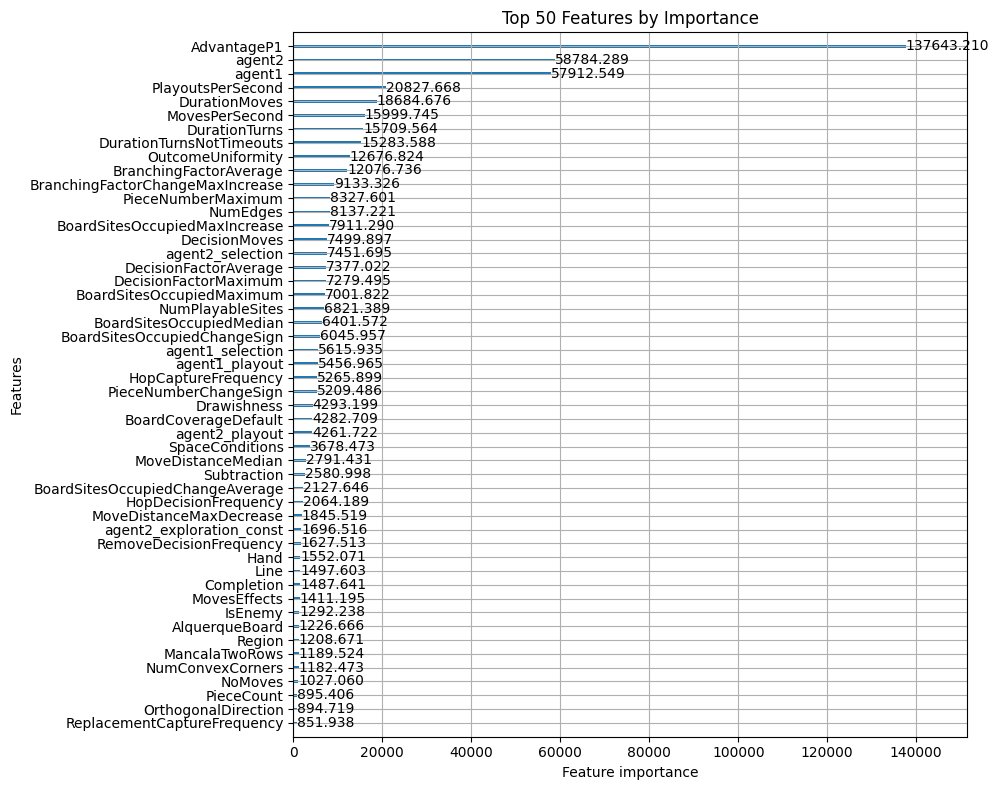

Fold 2 - RMSE: 0.45761239039632967
Fold 3
[100]	valid_0's rmse: 0.461469
[200]	valid_0's rmse: 0.447228
[300]	valid_0's rmse: 0.440945
[400]	valid_0's rmse: 0.437735
[500]	valid_0's rmse: 0.435677
[600]	valid_0's rmse: 0.434329
[700]	valid_0's rmse: 0.432919
[800]	valid_0's rmse: 0.431607
[900]	valid_0's rmse: 0.430325
[1000]	valid_0's rmse: 0.429448
[1100]	valid_0's rmse: 0.429219
[1200]	valid_0's rmse: 0.428511
[1300]	valid_0's rmse: 0.428304
[1400]	valid_0's rmse: 0.42796
[1500]	valid_0's rmse: 0.427791
[1600]	valid_0's rmse: 0.427242
[1700]	valid_0's rmse: 0.427003
[1800]	valid_0's rmse: 0.426658
[1900]	valid_0's rmse: 0.426672
[2000]	valid_0's rmse: 0.426573
[2100]	valid_0's rmse: 0.426498
[2200]	valid_0's rmse: 0.426383
[2300]	valid_0's rmse: 0.426297
[2400]	valid_0's rmse: 0.426288
[2500]	valid_0's rmse: 0.426244
[2600]	valid_0's rmse: 0.426153
[2700]	valid_0's rmse: 0.426075
[2800]	valid_0's rmse: 0.426143
[2900]	valid_0's rmse: 0.426167
[3000]	valid_0's rmse: 0.426131
[3100]	v

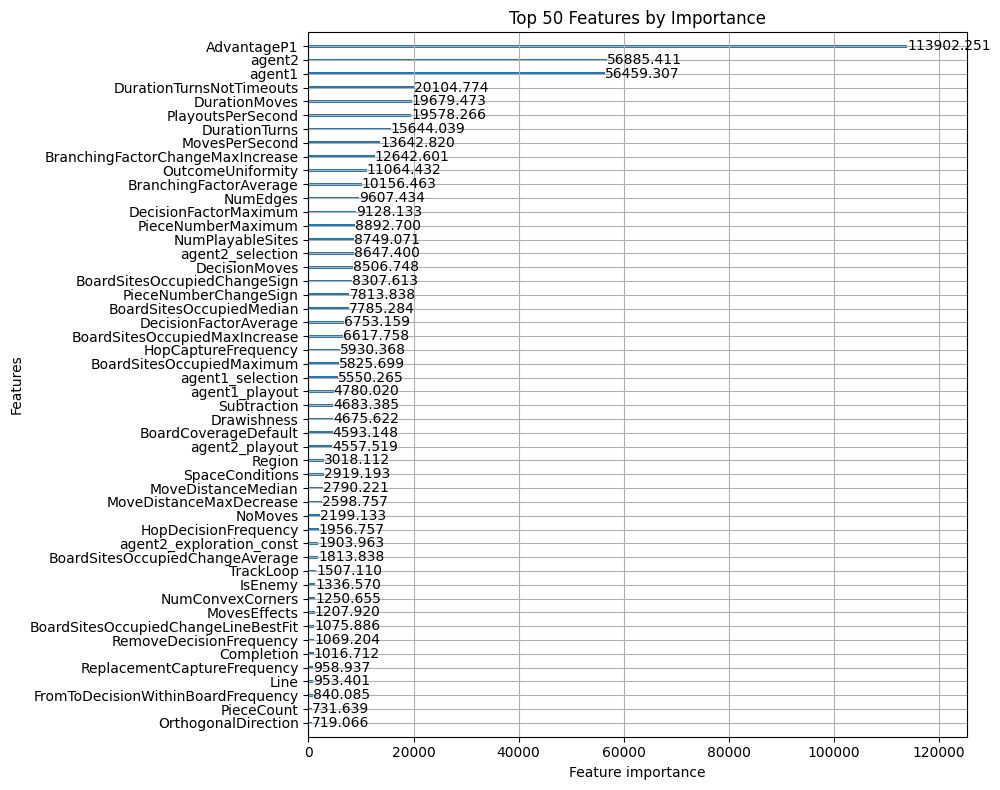

Fold 3 - RMSE: 0.4249983076310229
Fold 4
[100]	valid_0's rmse: 0.476421
[200]	valid_0's rmse: 0.460604
[300]	valid_0's rmse: 0.454015
[400]	valid_0's rmse: 0.449706
[500]	valid_0's rmse: 0.446898
[600]	valid_0's rmse: 0.444736
[700]	valid_0's rmse: 0.443115
[800]	valid_0's rmse: 0.44187
[900]	valid_0's rmse: 0.440988
[1000]	valid_0's rmse: 0.439761
[1100]	valid_0's rmse: 0.439138
[1200]	valid_0's rmse: 0.438642
[1300]	valid_0's rmse: 0.43812
[1400]	valid_0's rmse: 0.43777
[1500]	valid_0's rmse: 0.437522
[1600]	valid_0's rmse: 0.43707
[1700]	valid_0's rmse: 0.436693
[1800]	valid_0's rmse: 0.436468
[1900]	valid_0's rmse: 0.436173
[2000]	valid_0's rmse: 0.435966
[2100]	valid_0's rmse: 0.435614
[2200]	valid_0's rmse: 0.435522
[2300]	valid_0's rmse: 0.435276
[2400]	valid_0's rmse: 0.435078
[2500]	valid_0's rmse: 0.43499
[2600]	valid_0's rmse: 0.434769
[2700]	valid_0's rmse: 0.434605
[2800]	valid_0's rmse: 0.434674
[2900]	valid_0's rmse: 0.434777
[3000]	valid_0's rmse: 0.434923
[3100]	valid_

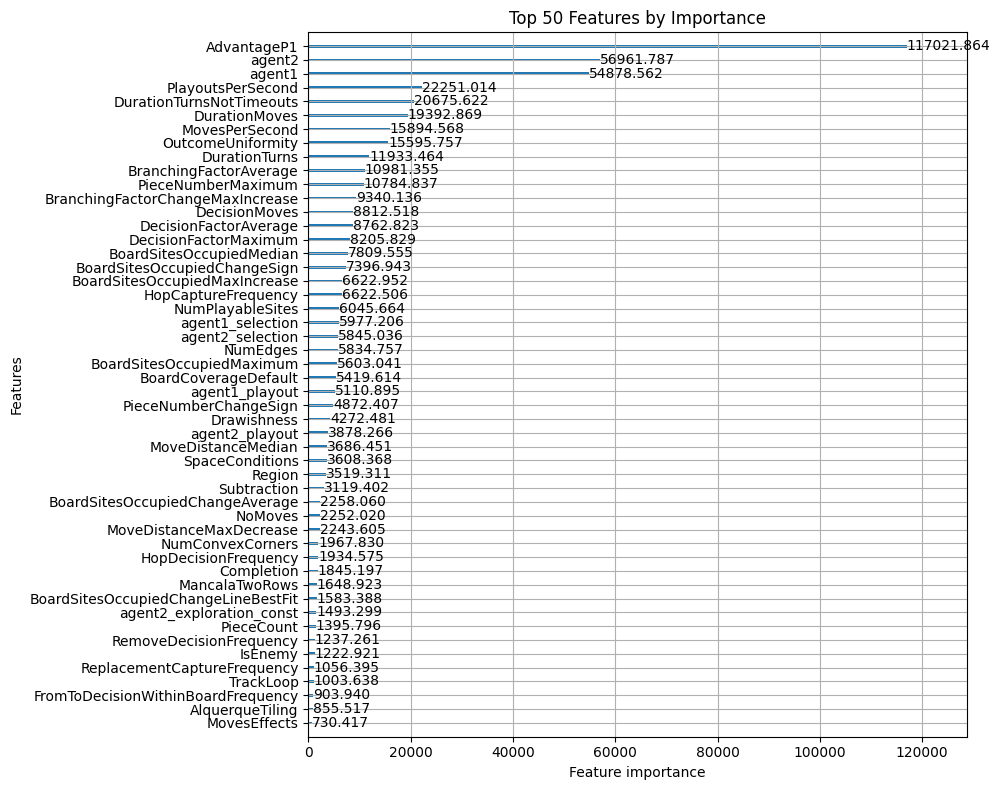

Fold 4 - RMSE: 0.43347095382892326
Fold 5
[100]	valid_0's rmse: 0.45107
[200]	valid_0's rmse: 0.43176
[300]	valid_0's rmse: 0.422441
[400]	valid_0's rmse: 0.417568
[500]	valid_0's rmse: 0.414581
[600]	valid_0's rmse: 0.412223
[700]	valid_0's rmse: 0.41023
[800]	valid_0's rmse: 0.409107
[900]	valid_0's rmse: 0.408012
[1000]	valid_0's rmse: 0.407582
[1100]	valid_0's rmse: 0.40686
[1200]	valid_0's rmse: 0.406254
[1300]	valid_0's rmse: 0.405714
[1400]	valid_0's rmse: 0.405244
[1500]	valid_0's rmse: 0.405138
[1600]	valid_0's rmse: 0.405004
[1700]	valid_0's rmse: 0.404667
[1800]	valid_0's rmse: 0.404271
[1900]	valid_0's rmse: 0.4039
[2000]	valid_0's rmse: 0.40375
[2100]	valid_0's rmse: 0.403491
[2200]	valid_0's rmse: 0.403358
[2300]	valid_0's rmse: 0.403297
[2400]	valid_0's rmse: 0.403121
[2500]	valid_0's rmse: 0.403226
[2600]	valid_0's rmse: 0.403177
[2700]	valid_0's rmse: 0.402961
[2800]	valid_0's rmse: 0.40276
[2900]	valid_0's rmse: 0.402777
[3000]	valid_0's rmse: 0.402739
[3100]	valid_0'

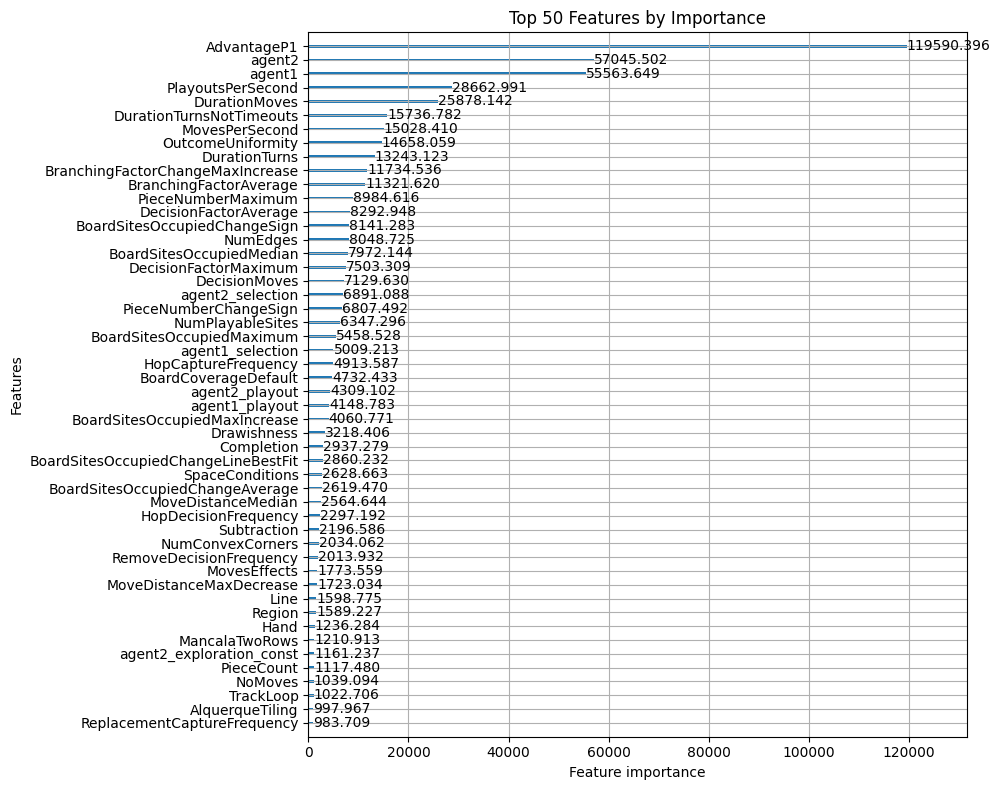

Fold 5 - RMSE: 0.4016986212887558
List of oof scores: [0.4251919318977863, 0.45761239039632967, 0.4249983076310229, 0.43347095382892326, 0.4016986212887558]
Average oof score: 0.42859444100856353


In [8]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
# oof1.to_csv(path_results / 'oof_lightgbm_cv1.csv', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_lightgbm_cv1.csv', index=False)


In [ ]:
# 0.4285
# 0.4316


In [9]:
# # call the function
# trained_models2, oof2, oof_scores2 = train_models(
#     df_train,
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=19,
# )
# # save oof predictions
# oof2.to_csv(path_results / 'oof_lightgbm_cv2.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train,
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=23,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_lightgbm_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

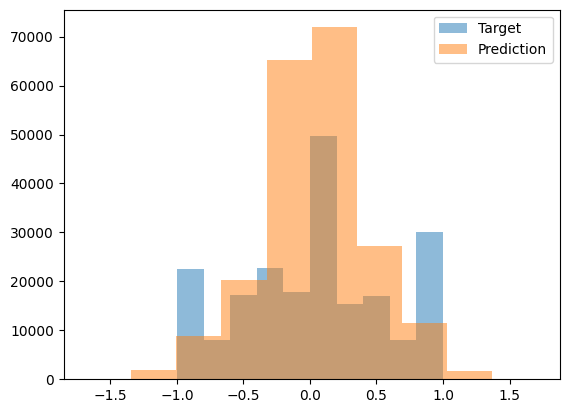

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.095658
233235,-0.13669
233236,-0.01673


In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open('./lightgbm_predict.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***